In [1]:

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")

In [2]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [3]:
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
dataOp425_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))
dataOp622_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-22\1'))
dataOp820_AL34 = wfOpto(Path(r'Y:\Subjects\AL_0034\2024-08-20\1'))

In [22]:
dataOp425_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [ ]:
dataVis824_AL23 = wfOpto(Path(r'Y:\Subjects\AL_0023\2024-08-24\1'))

In [4]:
dataVis830_AL23 = wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-30\1'))

In [14]:
dataVis904_AL35=wfOpto(Path(r'Y:\Subjects\AL_0035\2024-09-04\1'))

In [5]:
dataVis910_AL35=wfOpto(Path(r'Y:\Subjects\AL_0035\2024-09-10\1'))

In [6]:
dataVis823_ZYE=wfOpto(Path(r'Y:\Subjects\ZYE_0087\2024-08-19\1'))

In [5]:
linTest = np.load(Path(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\wf + opto\figure-making\linTestDff.npy'),allow_pickle=True)

In [6]:
linTest = linTest.item()

In [7]:
linWindows = np.load(Path(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\wf + opto\figure-making\linTestWindow.npy'),allow_pickle=True)

# a

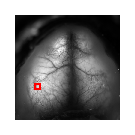

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(1, 1))
plt.imshow(dataVis910_AL35.meanImage,cmap='gray')
plt.axis('off')
# Center coordinates
center_x, center_y = 120, 380
# plt.scatter(x=center_x, y=center_y, s=5, c='red')

# Rectangle dimensions
width, height = 30, 30
# Calculate bottom-left corner coordinates
bottom_left_x = center_x - width / 2
bottom_left_y = center_y - height / 2

# Create rectangle with center as anchor point
rect = Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)
fig.savefig('paperposterfigs/3a_left.pdf',dpi=300,bbox_inches='tight')

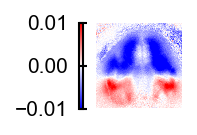

In [102]:
fig,ax=plt.subplots(1,1,figsize=(1.5,1))
data=dataVis910_AL35
power=3
galvoX=0;galvoY=0;start=0;end=1
frame=18
vmax=0.01
vmin=-0.01
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers==power).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY)
galvoXTrs=np.argwhere(data.galvoX==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
plt.axis('off')
cbar = plt.colorbar(location='left')
fig.savefig('paperposterfigs/3a_right.pdf',dpi=300)

# b

In [15]:
data=dataVis910_AL35
powers=np.unique(dataVis910_AL35.laserPowers)
galvoX=0;galvoY=0;x=400;y=400;width=15;anchor=(1,1)
ylim=[-0.01,0.05];start=-0.3;end=1;xlim=[-0.01,0.5]

n_samples = round(start*-1+end)*35
if len(powers)<3:
    colors=['deepskyblue','dodgerblue','mediumblue']
else:
    colors=plt.cm.inferno(np.linspace(.4,1,6))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX[0:600]==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY[0:600]==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

meanimg = data.meanImage.reshape(560,560,-1)
avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

for power in powers:
    pwTrs = np.argwhere(data.laserPowers[0:600]== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = videoROI_avg/avg
        trial_activity.append(dff)
    sems.append(scipy.stats.sem(trial_activity,axis=0))
    pxPowers.append(np.mean(trial_activity,axis=0))

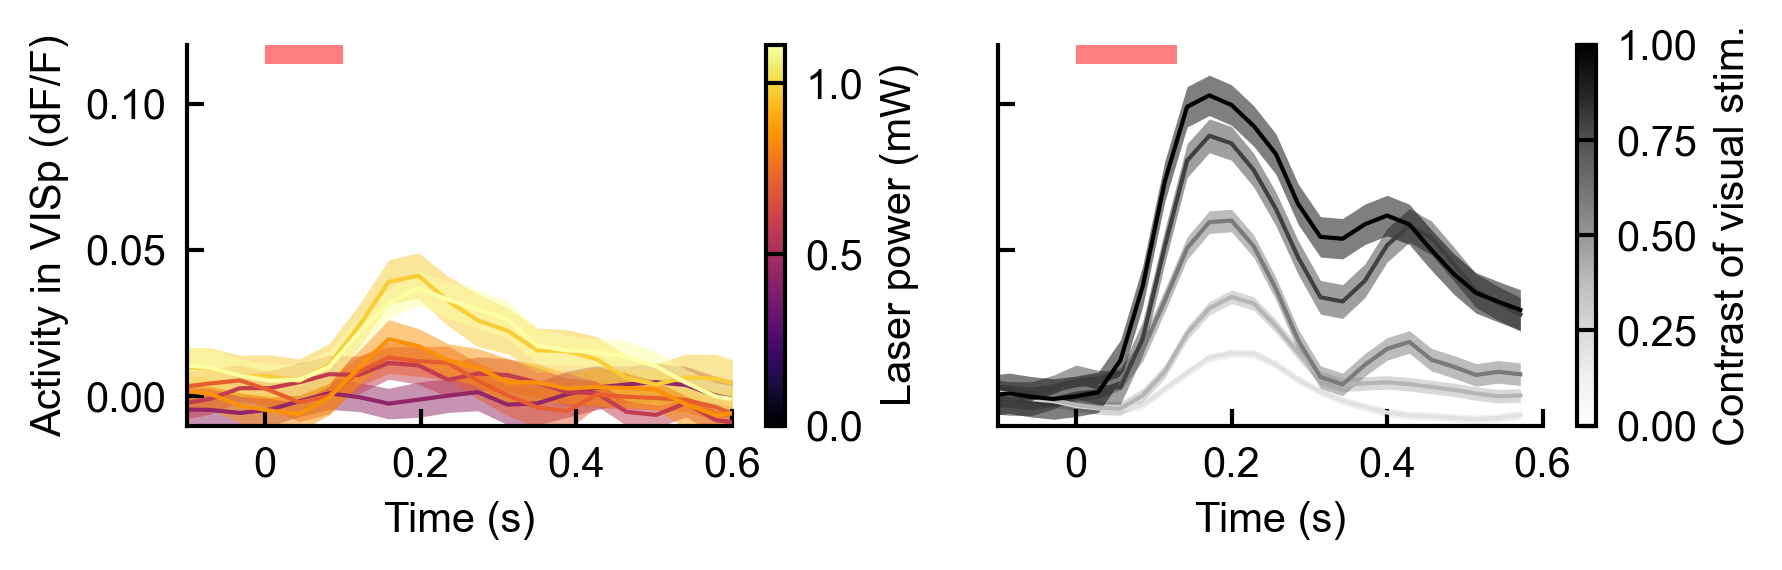

In [89]:
fig=plt.figure(figsize=(6,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]

ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    
    # legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize=fontsizelegend,\
    #                     columnspacing=0.5,handletextpad=0.3)
    
    # Change the color of the text in the legend to match the line colors
    # for text, line in zip(legend.get_texts(), lines):
    #     text.set_color(line.get_color())
    # # Optionally, remove the lines and markers from the legend
    # for legend_line in legend.get_lines():
    #     legend_line.set_linewidth(0)
    # for legend_marker in legend.get_patches():
    #     legend_marker.set_visible(False)
plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
plt.xlim([-.1,0.6])
plt.xticks([0,0.2,0.4,0.6],[0,0.2,0.4,0.6])
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 3/2.7) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
plt.ylim([-.01,.12])
plt.xlabel('Time (s)')
plt.ylabel('Activity in VISp (dF/F)')
# plt.savefig('paperposterfigs/visresp.pdf',dpi=300)

ax=plt.subplot(gs[0,1])
colors_grey = plt.cm.Greys(np.linspace(0.2,1,5))
for i,key in enumerate(linTest.keys()):
    contrast = np.mean(linTest.get(key),axis=0)
    plt.plot(linWindows,contrast,color=colors_grey[i])
    plt.fill_between(linWindows, \
            contrast-scipy.stats.sem(contrast,axis=0),\
            contrast+scipy.stats.sem(contrast,axis=0), color=colors_grey[i],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.130,ymin=0.95,ymax=1,color='red',alpha=0.5,lw=0)
plt.xlabel('Time (s)')
plt.xlim([-.1,0.6])
plt.xticks([0,0.2,0.4,0.6],[0,0.2,0.4,0.6])
plt.ylim([-.01,.12])
ax.tick_params(labelleft=False)
# plt.yticks([0, 0.05, 0.1], ['', '', ''])
cm = mpl.cm.ScalarMappable(cmap='Greys') # creates a color mapping object
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7:.1f} mW') # the power variable is in V (taken from data npys)
plt.colorbar(ax=ax,mappable=cm,label='Contrast of visual stim.') # tells the colorbar to use your colormap object


fig.tight_layout()
fig.savefig('paperposterfigs/visresp_and_lintest.pdf',dpi=300)

In [121]:
linTest.keys()

dict_keys([0.0625, 0.125, 0.25, 0.5, 1.0])

In [8]:
for key in linTest.keys():
    contrast = np.mean(linTest.get(key),axis=0)
    print(max(contrast))

0.014677306195801468
0.03393555858059293
0.06002743028766655
0.08898880270952218
0.10280229210256235


# c

In [74]:
def respQuantLoc(ax,data,galvoYList,powers,x=100,y=390,\
                 time=0.18,width=50,title='',ylim=[-0.1,0.04]):
    '''
    plots 3 traces for 3 different locations to compare the activation of the visual cortex per location
    '''
    pxData=[]
    sems_final=[]
    labels=['Ant','Mid','Post']
    colors = plt.cm.Purples(np.linspace(.3,1,len(galvoYList)))
    start=0
    end=.5
    time=0.18
    n_samples = round((start+end)*35)
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for iD,yLoc in enumerate(galvoYList):
        pxPowers = []
        sems=[]
        galvoYTrs=np.argwhere(data.galvoY==yLoc).ravel()

        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[:600] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,galvoYTrs)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
        pxData.append(pxPowers)
        sems_final.append(sems)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    for iD,data in enumerate(pxData):
        plt.plot(powerscorr,data,'-o',c=colors[iD],lw=2,label=labels[iD])
        plt.errorbar(powerscorr,data,yerr=sems_final[iD],c=colors[iD],label='_nolabel_')
        plt.scatter(powerscorr,data,label='_nolabel_')
    # plt.legend(loc='upper left')
    plt.xlabel("Laser power (mW)")
    plt.ylim(ylim)
    plt.ylabel(f'Activity at peak in Visp (dF/F)')

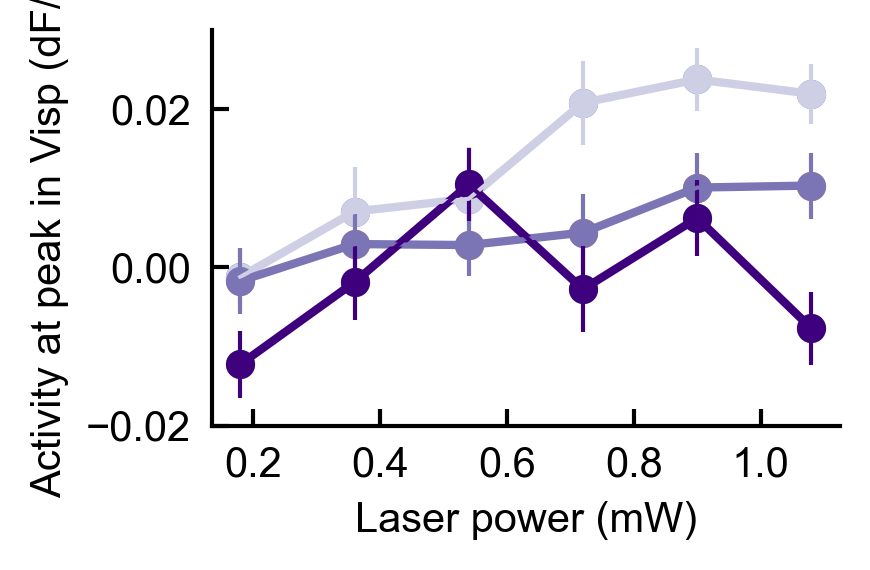

In [75]:
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
respQuantLoc(ax,dataVis904_AL35,[0,2,3.5],powers=np.unique(dataVis904_AL35.laserPowers),\
             x=100,y=390,time=0.18,width=50,title='',ylim=[-0.02,0.03])
fig.savefig('paperposterfigs/fig3c_3x2.pdf',dpi=300)

# e

In [112]:
def visRespCompare(ax,data,ylim,xlim,exptrs=np.array([0,600,1200]),power=2.5,start=-.3,end=1,\
                   galvoX=0,galvoY=0,x=120,y=380,width=15,title="Response in VisP",\
                   labels=['No Flicker','Flicker'],legend=True):
    '''
    trace of response in VC compared with and without flicker 
    '''
    xTrace = []
    sems=[]
    colors=['forestgreen','orange']
    labels=['No Flicker','Flicker']
    n_samples=round(start*-1+end)*35
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    
    for i in range(2):
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        xTrace.append(np.mean(trial_activity,axis=0))

    for iP, trace in enumerate(xTrace):
        plt.plot(timestamps,trace, label=labels[iP], color=colors[iP])
        plt.fill_between(timestamps, \
                trace-sems[iP],\
                trace+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    plt.legend()
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(.2))
    plt.xlabel('Time (ms)',fontsize=10)
    plt.ylabel('Activity in Visp (dF/F)',fontsize=10)
    plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5,label='_nolegend_')
    plt.legend()
    plt.ylim(ylim)
    plt.xlim(xlim)

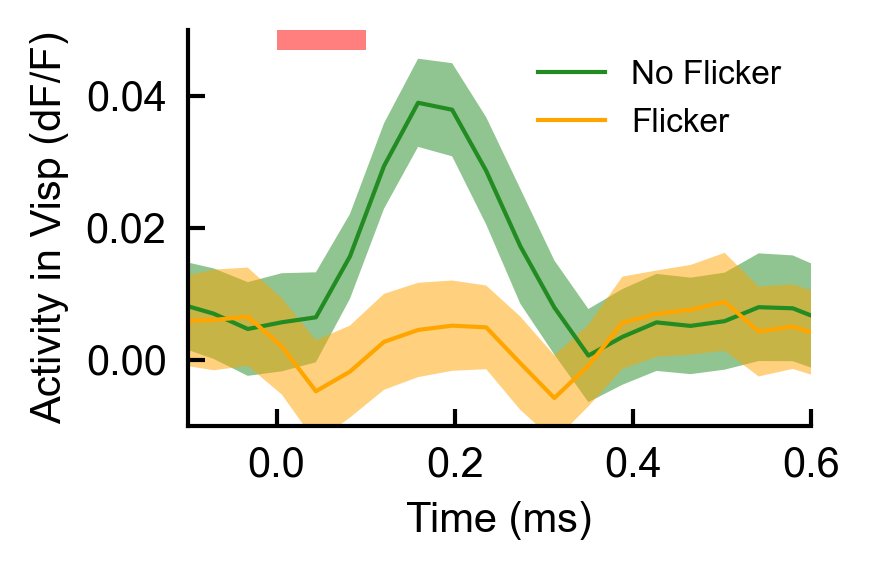

In [115]:
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
visRespCompare(ax,dataVis910_AL35,[-0.01,0.05],[-0.1,0.6])
fig.savefig('paperposterfigs/fig3f_3x2.pdf',dpi=300)

# f

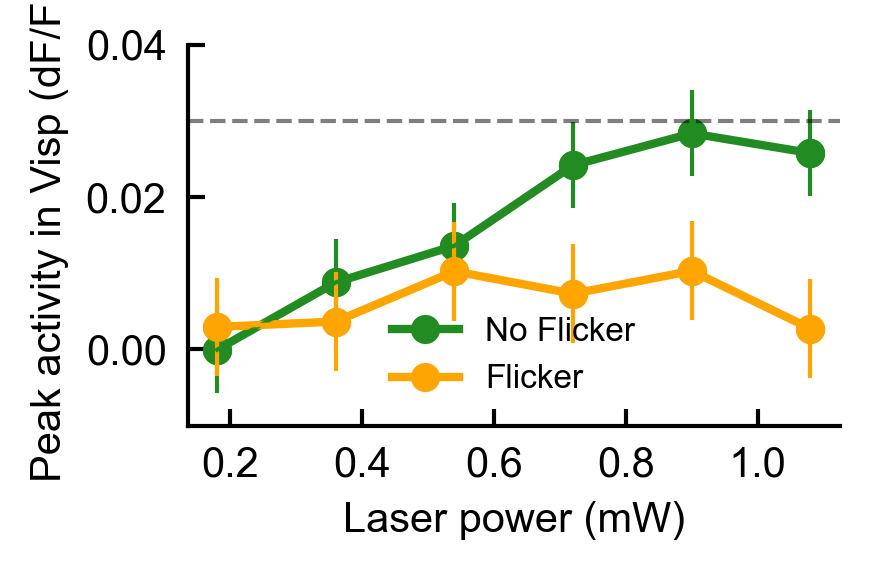

In [20]:
data=dataVis904_AL35
exptrs=np.array([0,600,1200])
galvoX=0;galvoY=0;x=120;y=380;width=30
time=0.18
ylim=[-0.01,0.04]

colors=['forestgreen','orange']
labels=['No Flicker', 'Flicker']

powers = np.unique(data.laserPowers).ravel()
lenpws = len(powers)

quantCompare = np.zeros((2,lenpws),dtype=float)
semsCompare = np.zeros((2,lenpws),dtype=float)
n_samples=round(0.3+1)*35
timestamps = np.linspace(-0.3, 1, n_samples)

meanimg = data.meanImage.reshape(560,560,-1)
avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

noadapt_peaks_power=[]
adapt_peaks_power=[]
for i in range(2):
    pxPowers=[]
    sems=[]
    tr1 = exptrs[i]
    tr2 = exptrs[i+1]
    galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        trial_peaks=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
            trial_peaks.append(pixelInterpTrial(time))
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_peaks,axis=0))
        pxPowers.append(np.mean(trial_peaks,axis=0))
    quantCompare[i]=pxPowers
    semsCompare[i]=sems

fig,ax=plt.subplots(figsize=(3,2),dpi=300)
powerscorr = [round(i/2.777777778,2) for i in powers]
for i,peaks in enumerate(quantCompare):
    plt.plot(powerscorr,peaks,'-o',c=colors[i],lw=2,label=labels[i])
    plt.errorbar(powerscorr,peaks,yerr=sems[i],c=colors[i],label='_nolabel_')
    plt.scatter(powerscorr,peaks,c=colors[i],label='_nolabel_')
plt.legend()
plt.axhline(0.03,linestyle='--',color='black',alpha=0.5)
plt.xlabel("Laser power (mW)")
plt.ylabel("Peak activity in Visp (dF/F)")
plt.ylim(ylim)
fig.savefig('paperposterfigs/fig3e_3x2.pdf',dpi=300)

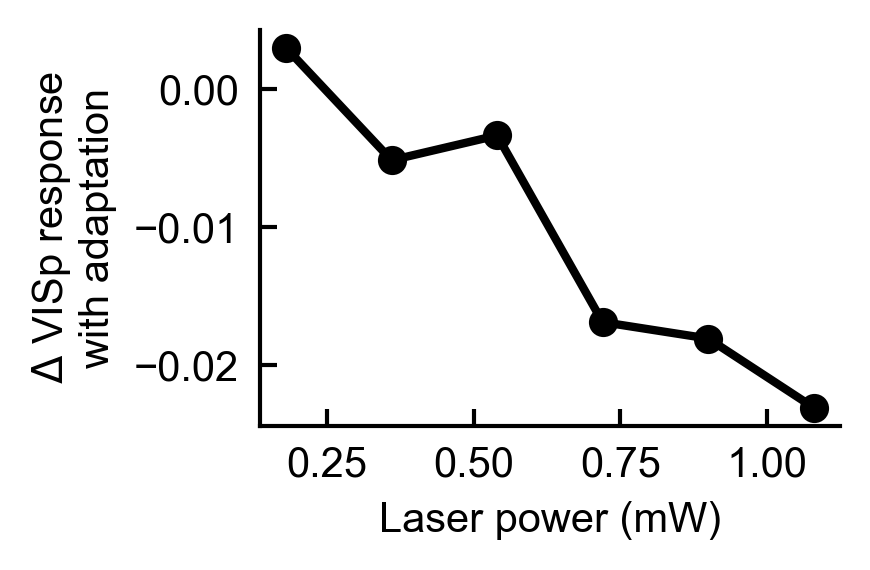

In [16]:
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
diff_adapt = quantCompare[1]-quantCompare[0]
plt.plot(powerscorr,diff_adapt,'-o',lw=2,color='k')
plt.xlabel('Laser power (mW)')
plt.ylabel(f'$\Delta$ VISp response\nwith adaptation')
fig.savefig('paperposterfigs/fig3f_right_3x2.pdf',dpi=300)

# g

In [41]:
1/2.777777778

0.3599999999712

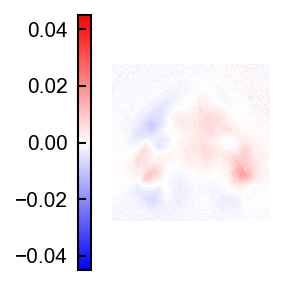

In [66]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
data=dataVis910_AL35
power=1
galvoX=0;galvoY=0;start=0;end=1
frame=6
vmax=0.045
vmin=-0.045
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers[600:]==power).ravel()
galvoYTrs=np.argwhere(data.galvoY[600:]==galvoY)
galvoXTrs=np.argwhere(data.galvoX[600:]==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
plt.axis('off')
cbar = plt.colorbar(location='left')
fig.savefig('paperposterfigs/3a_right.pdf',dpi=300)

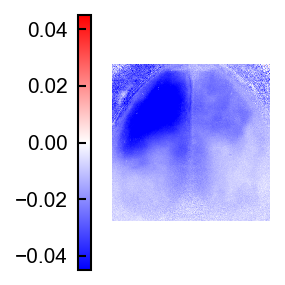

In [67]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
data=dataOp425_AB32
power=1
galvoX=0;galvoY=0;start=0;end=1
frame=4
vmax=0.045
vmin=-0.045
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers==power).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY)
galvoXTrs=np.argwhere(data.galvoX==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
plt.axis('off')
cbar = plt.colorbar(location='left')
fig.savefig('paperposterfigs/3a_left.pdf',dpi=300)

# h

In [9]:
def powerQuantReturn(data,powers,galvoX=0,galvoY=0,start=0,end=.5,x=150,y=380,n_samples=300,time=90,width=15):
    '''
    returns time at peak values into a variable which can later be used/compared
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    n_samples=round((end-start) * 35)
    timestamps = np.linspace(start,end, n_samples)
    pxPowers = []
    sems=[]
    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
            
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        trial_peaks=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
            trial_peaks.append(pixelInterpTrial(time))
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_peaks,axis=0))
        pxPowers.append(np.mean(trial_peaks,axis=0))

    return pxPowers,sems

In [10]:
def powerQuantReturnTrs(data,powers,galvoX=0,galvoY=0,start=0,end=.5,x=150,y=380,n_samples=300,time=90,width=15,expTrs=[0,600,1200]):
    n_samples=round((end-start) * 35)
    timestamps = np.linspace(start,end, n_samples)
    pxPowers = []
    sems=[]
    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    powersTotal=[]
    semsTotal=[]
    for i in range(2):
        tr1=expTrs[i]
        tr2=expTrs[i+1]
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        pxPowers=[]
        sems=[]
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
        powersTotal.append(pxPowers)
        semsTotal.append(sems)

    return powersTotal,semsTotal

## opto

In [35]:
pxPowers_opto=[]
sems_opto=[]
for data in [dataOp425_AB32, dataOp622_AL33, dataOp820_AL34]:
    pxPowers,sems = powerQuantReturn(data,np.unique(data.laserPowers),galvoX=0,galvoY=0,x=200,y=100,width=100,time=0.09)
    pxPowers_opto.append(pxPowers)
    sems_opto.append(sems)

In [39]:
np.save('pxPowers_opto.npy',pxPowers_opto)
np.save('sems_opto.npy',sems_opto)

In [18]:
pxPowers_opto = np.load('pxPowers_opto.npy',allow_pickle=True)

In [19]:
sems_opto = np.load('sems_opto.npy',allow_pickle=True)

In [12]:
powers11 = np.unique(dataOp425_AB32.laserPowers)

## ctrl adapt

al23 x=420 y=410

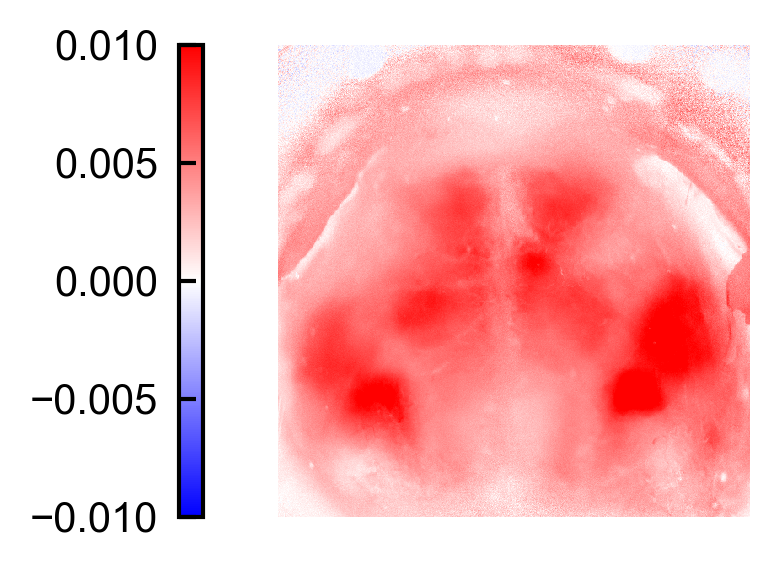

In [51]:
f = plt.figure(figsize=(3,2),dpi=300)
data=dataVis830_AL23
power=3
galvoX=0;galvoY=0;start=0;end=1
frame=7
vmax=0.01
vmin=-0.01
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers[:1350]==power).ravel()
galvoYTrs=np.argwhere(data.galvoY[:1350]==galvoY)
galvoXTrs=np.argwhere(data.galvoX[:1350]==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.axis('off') 
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
cbar = plt.colorbar(location='left')
# plt.scatter(x=420,y=410,s=5,c='green')
plt.savefig('paperposterfigs/3a_right.pdf',dpi=300)

(-0.5, 559.5, 559.5, -0.5)

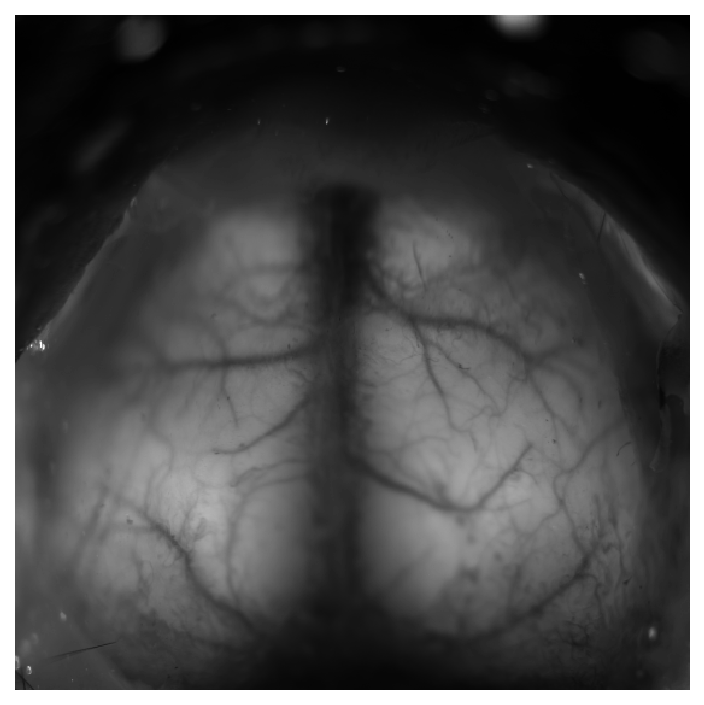

In [54]:
plt.imshow(dataVis830_AL23.meanImage,cmap='gray')
plt.savefig('paperposterfigs/3a_left.pdf',dpi=300)
plt.axis('off')

In [11]:
pxPowers_AL23, sems_AL23 = powerQuantReturnTrs(dataVis830_AL23,np.unique(dataVis830_AL23.laserPowers),\
                                               galvoX=0,galvoY=0,x=420,y=410,width=15,expTrs=[0,1350,1800],\
                                                time=0.18)

In [53]:
np.array(pxPowers_AL23).shape

(2, 9)

In [61]:
np.save('pxPowers_AL23.npy',pxPowers_AL23)
np.save('sems_AL23.npy',sems_AL23)

In [8]:
pxPowers_AL23 = np.load('pxPowers_AL23.npy',allow_pickle=True)
sems_AL23 = np.load('sems_AL23.npy',allow_pickle=True)

zye87 x=450 y=480

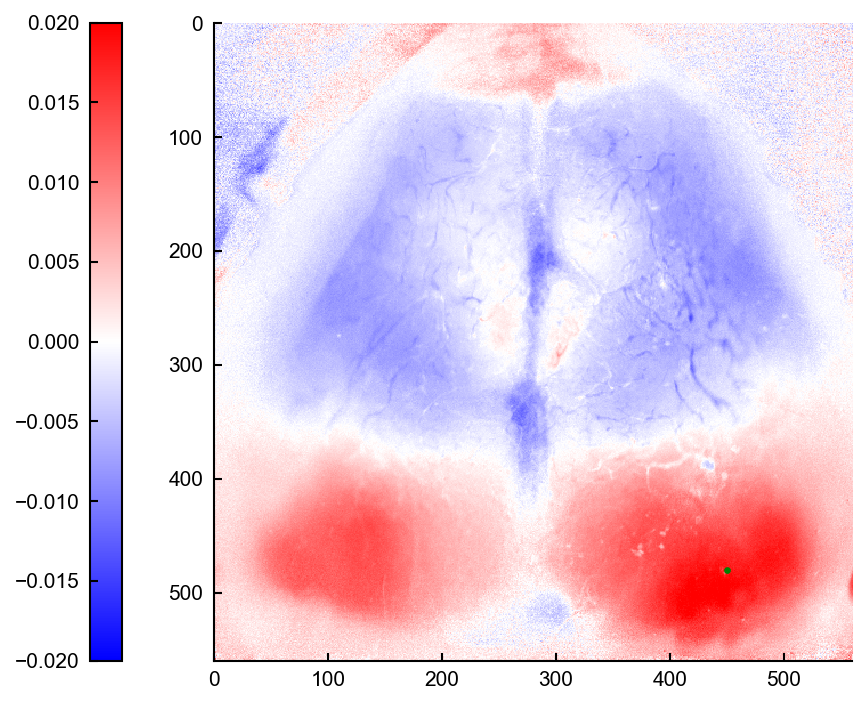

In [58]:
data=dataVis823_ZYE
power=2.5
galvoX=0;galvoY=0;start=0;end=1
frame=7
vmax=0.02
vmin=-0.02
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers[:1350]==power).ravel()
galvoYTrs=np.argwhere(data.galvoY[:1350]==galvoY)
galvoXTrs=np.argwhere(data.galvoX[:1350]==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
cbar = plt.colorbar(location='left')
plt.scatter(x=450,y=480,s=5,c='green')

In [12]:
pxPowers_ZYE, sems_ZYE = powerQuantReturnTrs(dataVis823_ZYE,np.unique(dataVis823_ZYE.laserPowers),\
                                               galvoX=0,galvoY=0,x=450,y=450,width=15,expTrs=[0,600,1200],\
                                                time=0.18)

In [60]:
np.save('pxPowers_ZYE.npy',pxPowers_ZYE)
np.save('sems_ZYE.npy',sems_ZYE)

In [9]:
pxPowers_ZYE = np.load('pxPowers_ZYE.npy',allow_pickle=True)

In [10]:
sems_ZYE = np.load('sems_ZYE.npy',allow_pickle=True)

al35

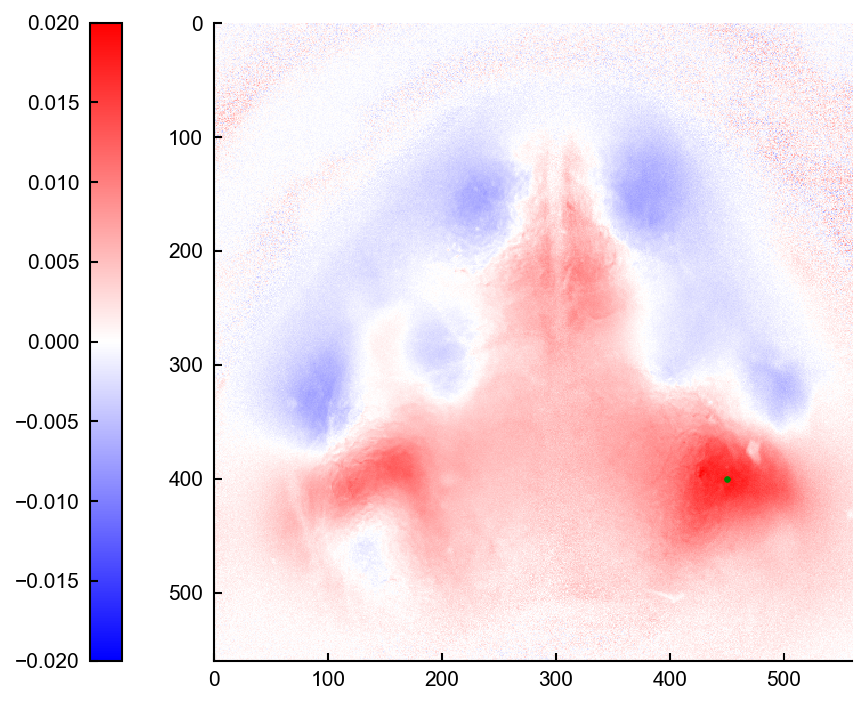

In [66]:
data=dataVis910_AL35
power=1.5
galvoX=0;galvoY=0;start=0;end=1
frame=7
vmax=0.02
vmin=-0.02
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers[:1350]==power).ravel()
galvoYTrs=np.argwhere(data.galvoY[:1350]==galvoY)
galvoXTrs=np.argwhere(data.galvoX[:1350]==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
cbar = plt.colorbar(location='left')
plt.scatter(x=450,y=400,s=5,c='green')

In [13]:
pxPowers_AL35, sems_AL35 = powerQuantReturnTrs(dataVis910_AL35,np.unique(dataVis910_AL35.laserPowers),\
                                               galvoX=0,galvoY=0,x=450,y=400,width=15,expTrs=[0,600,1200],
                                               time=0.18)

In [59]:
np.save('pxPowers_AL35.npy',pxPowers_AL35)
np.save('sems_AL35.npy',sems_AL35)

In [11]:
pxPowers_AL35 = np.load('pxPowers_AL35.npy',allow_pickle=True)
sems_AL35 = np.load('sems_AL35.npy',allow_pickle=True)

## plot

In [16]:
ctrl_pows = [pxPowers_AL23,pxPowers_ZYE,pxPowers_AL35]
ctrl_sems=[sems_AL23,sems_ZYE,sems_AL35]

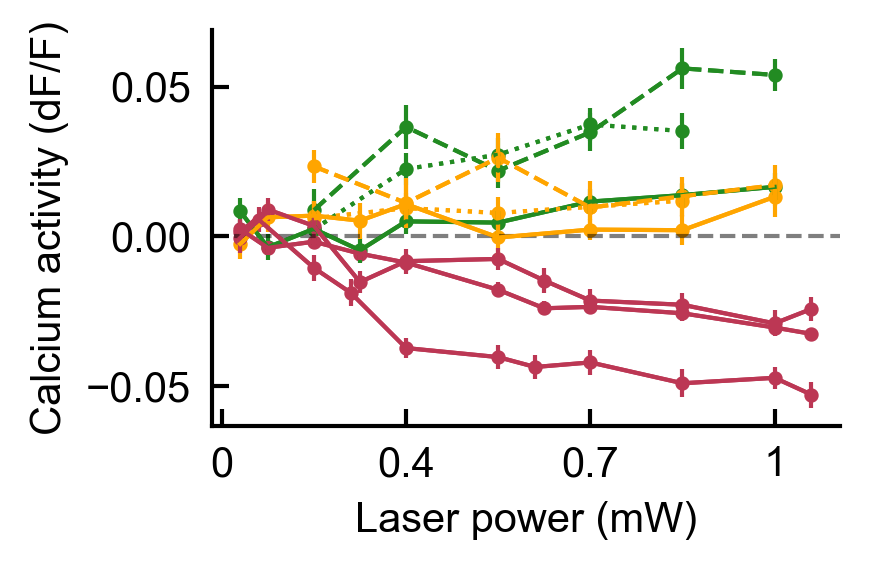

In [58]:
f=plt.figure(figsize=(3,2),dpi=300)

datacontrol = [[0.10, 0.25, 0.50, 0.75, 1.00, 1.50, 2.0, 2.5, 3.0],
               [0.5, 1, 1.5, 2, 2.5],
               [0.5, 1, 1.5, 2, 2.5, 3]]
dataOpPowers=[[0.1,0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2],
              [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.5, 3, 3.2],
              [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.5, 3, 3.2]
]
infernocolor = plt.cm.inferno(np.linspace(0,1,11))
colors=['forestgreen','orange']
linestyles=['-',':','--']
for i in range(2):
    for j in range(3):
        data = datacontrol[j]
        pows=ctrl_pows[j][i]
        sems=ctrl_sems[j][i]
        c=colors[i]

        powers=np.unique(datacontrol[j])
        plt.plot(powers,pows,color=c,linestyle=linestyles[j])
        plt.errorbar(powers,pows,yerr=sems,color=c,linestyle=linestyles[j])
        plt.scatter(powers,pows,color=c,s=6)

oc=infernocolor[5]
for i in range(3):
    pws=np.unique(dataOpPowers[i])
    plt.plot(pws,pxPowers_opto[i],color=oc)
    plt.errorbar(pws,pxPowers_opto[i],yerr=sems_opto[i],color=oc)
    plt.scatter(pws,pxPowers_opto[i],color=oc,s=6)

plt.axhline(0.00,linestyle='--',color='black',alpha=0.5)
plt.xticks([0,1,2,3],[0,0.4,0.7,1])
plt.xlabel("Laser power (mW)")
plt.ylabel('Calcium activity (dF/F)')
f.savefig('paperposterfigs/fig3h_3x2.pdf',dpi=300)

In [30]:
3/2.7778

1.0799913600691193

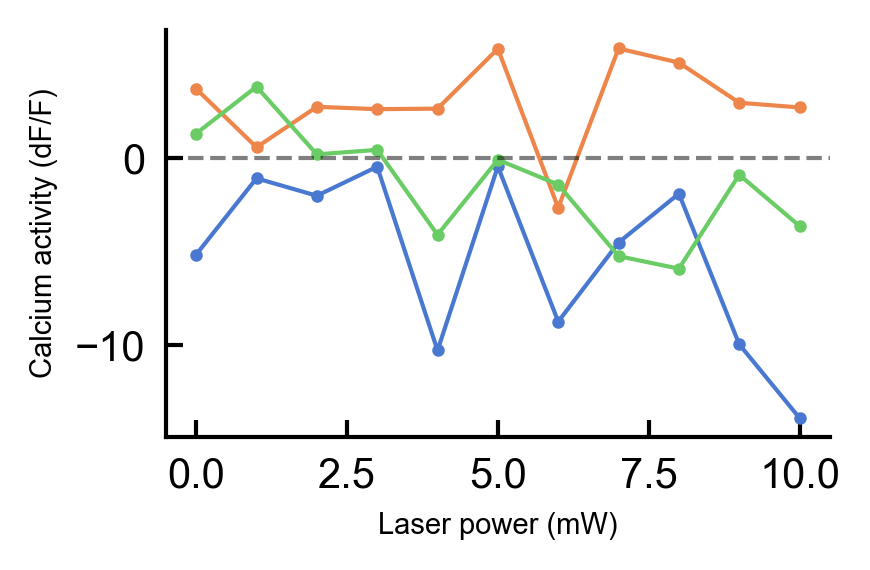

In [77]:
f = plt.figure(figsize=(3,2), dpi=300)
# powers11=np.unique(dataOp425_AB32.laserPowers)
# powers = [round(i/2.777777778,2) for i in powers11]
# colors=['mediumpurple','hotpink']
# labels=['opto','control']


for i,mouse in enumerate(pxPowers_opto):
    plt.plot(mouse,'-o',lw=1,markersize=2)

    # plt.errorbar(powers,mouse,yerr=sems_opto[i],c=colors[i])

    # plt.scatter(powers,mouse,label='_nolegend_',c=colors[i],s=.5)
    
cols=1
anchor=(1,1)

plt.xlabel("Laser power (mW)",fontsize=7)
plt.ylabel("Calcium activity (dF/F)",fontsize=7)
plt.axhline(y=0,color='black',linestyle='--',alpha=0.5)
# plt.ylim(-0.09,0.05)
f.savefig('paperposterfigs/fig3h_3x2.pdf',dpi=300)

## old

In [62]:
dataVis=dataVis910_AL35
dataOp=dataOp425_AB32
powers5 = np.unique(dataVis.laserPowers)

vis,visem = powerQuantReturn(data=dataVis,powers=powers5,galvoX=0,galvoY=0,x=120,y=380,time=.18,width=30)
opto,optosem = powerQuantReturn(data=dataOp,powers=np.unique(dataOp.laserPowers),galvoX=0,galvoY=0,x=100,y=200,time=.09,width=50)

interp_func = scipy.interpolate.interp1d(powers5, vis, kind='linear', fill_value='extrapolate')
controlinterp = interp_func(np.unique(dataOp.laserPowers))


In [63]:
interp_sem = scipy.interpolate.interp1d(powers5,visem,kind='linear',fill_value='extrapolate')
controlinterpsem = interp_sem(np.unique(dataOp.laserPowers))
sem=[optosem,controlinterpsem]